In [4]:
import os
import pandas as pd
import numpy as np
from itertools import product
from matplotlib import pyplot as plt

In [2]:
# load all book indices into storage and create a set of wikipedia concepts
path = "../dat/index_by_wiki/"
wiki_concepts = set()
indices = {}

def get_smallest_page(pages):
    if not isinstance(pages, float) and "nan" in pages: return None
    pages_int = [int(pages)] if isinstance(pages, float) else list(map(int, pages.split(",")))
    return min(pages_int)

for book in os.listdir(path):
    index = pd.read_csv(path + book).dropna()
    index['first_page'] = index.pages.apply(get_smallest_page) # add first page of index entry
    indices[book] = index
    wiki_concepts.update(index.wiki_concept) # add new concepts to set

wiki_list = list(wiki_concepts)
n = len(wiki_concepts)
print(str(len(wiki_concepts)) + " wikipedia concepts in total")

1303 wikipedia concepts in total


In [3]:
# compare a single pair of concepts
concept1 = wiki_list[2]
concept2 = wiki_list[1302]

for book, index in indices.items(): # over all books
    if concept1 in index.wiki_concept.values and concept2 in index.wiki_concept.values: # both concepts in this book
        first = index.first_page.iloc[index.wiki_concept.values==concept1].values[0]
        second = index.first_page.iloc[index.wiki_concept.values==concept2].values[0]
        print(concept1 + (" *before* " if first<second else " *after* ") + concept2 + " in " + book)
    else:
        print("Pair not in " + book)

Pair not in Beezer_First_Course.csv
Pair not in CollegeAlgCoreq-WEB.csv
Pair not in Hefferon_LinAlgebra.csv
Pair not in interactive_textbook.csv
Pair not in Kuttler-LinearAlgebra-AFirstCourse-2017A.csv
Pair not in Linear algebra done right — Axler.csv
Pair not in linear-Cherey, Denton.csv
Pair not in Math1410_print.csv
Companion matrix *before* Expectation in Nicholson-OpenLAWA-2019A.csv
Pair not in textbook_Hoffman_Kunze.csv


In [4]:
# create 3D array with concept pair in the first two dimensions and book in the third dimension
adj = np.tile(np.nan, (n,n,len(indices.keys())))

for idx, index in enumerate(indices.values()):
    def get_first_page_for_concept(concept):
        vals = index.first_page.iloc[index.wiki_concept.values==concept].values
        return vals[0] if len(vals) else None
    first_pages = list(map(get_first_page_for_concept, wiki_concepts))
    combinations = product(first_pages, first_pages)
    comparisons = [
        1 * (page1 < page2) if page1 is not None and page2 is not None
        else None
        for (page1, page2) in combinations
    ]
    comparisons_2d = np.array(comparisons).reshape((n,n))
    np.fill_diagonal(comparisons_2d, None)
    adj[:,:,idx] = comparisons_2d

mean_adj = np.nanmean(adj,axis=2) # voting: percentage of books that would keep this edge

C:\Users\anast\AppData\Local\Temp\ipykernel_2928\3359931180.py:19: RuntimeWarning: Mean of empty slice
  mean_adj = np.nanmean(adj,axis=2) # voting: percentage of books that would keep this edge


## How much information do we have about our 848,253 pairs?

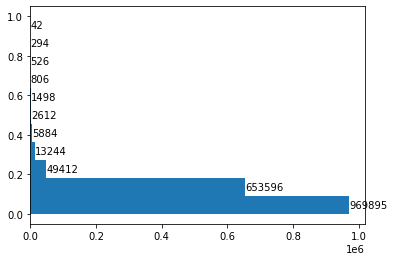

In [5]:
adj_info = np.invert(np.isnan(adj)).mean(axis=2)
counts, edges, bars = plt.hist(adj_info.ravel(),bins=11, orientation="horizontal")
plt.bar_label(bars)
plt.show()

## What is the distribution of comparison results?

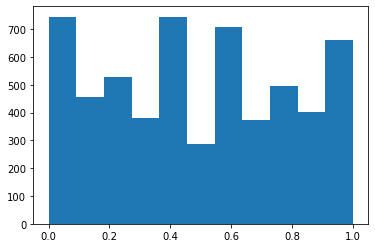

In [6]:
# let's only look at the comparisons where we have at least 5 books with both pairs in it
plt.hist(mean_adj[np.where(adj_info>=0.5)], bins=11)
plt.show()

## What are actual predicted dependencies?

In [7]:
idx = np.where(adj_info > .8)
np_wiki = np.array(wiki_list)

# print clear dependencies
np.array(list(zip(np_wiki[idx[0]], np_wiki[idx[1]], np.round(mean_adj[idx],1))))[np.where(mean_adj[idx]>.7)]

array([['Invertible matrix', 'Linear span', '0.8'],
       ['Invertible matrix', 'Diagonalizable matrix', '0.9'],
       ['Invertible matrix', 'Basis', '0.8'],
       ['Matrix multiplication', 'Linear span', '0.9'],
       ['Matrix multiplication', 'Transpose', '0.8'],
       ['Matrix multiplication', 'Eigenvalues and eigenvectors', '0.8'],
       ['Matrix multiplication', 'Diagonalizable matrix', '1.0'],
       ['Matrix multiplication', 'Basis', '0.9'],
       ['Matrix multiplication', 'Determinant', '0.8'],
       ['Linear span', 'Diagonalizable matrix', '0.9'],
       ['Linear span', 'Basis', '0.9'],
       ['Scalar multiplication', 'Identity matrix', '0.8'],
       ['Scalar multiplication', 'Determinant', '0.8'],
       ['Transpose', 'Eigenvalues and eigenvectors', '0.8'],
       ['Transpose', 'Diagonalizable matrix', '1.0'],
       ['Matrix (mathematics)', 'Invertible matrix', '0.8'],
       ['Matrix (mathematics)', 'Linear span', '0.8'],
       ['Matrix (mathematics)', 'Scalar mu

In [8]:
# print unclear dependencies
np.array(list(zip(np_wiki[idx[0]], np_wiki[idx[1]], np.round(mean_adj[idx],1))))[np.where((mean_adj[idx]<.7)&(mean_adj[idx]>.3))]

array([['Invertible matrix', 'Scalar multiplication', '0.4'],
       ['Invertible matrix', 'Transpose', '0.7'],
       ['Invertible matrix', 'Row and column spaces', '0.6'],
       ['Invertible matrix', 'Identity matrix', '0.5'],
       ['Invertible matrix', 'Complex number', '0.6'],
       ['Invertible matrix', 'Row and column vectors', '0.3'],
       ['Invertible matrix', 'Linear independence', '0.7'],
       ['Invertible matrix', 'Rank (linear algebra)', '0.3'],
       ['Invertible matrix', 'Triangular matrix', '0.4'],
       ['Invertible matrix', 'Eigenvalues and eigenvectors', '0.7'],
       ['Invertible matrix', 'Determinant', '0.6'],
       ['Invertible matrix', 'Linear map', '0.6'],
       ['Matrix multiplication', 'Scalar multiplication', '0.4'],
       ['Matrix multiplication', 'Row and column spaces', '0.4'],
       ['Matrix multiplication', 'Complex number', '0.6'],
       ['Matrix multiplication', 'Row and column vectors', '0.6'],
       ['Matrix multiplication', 'Linear i

### DE1. Removing dependencies that cannot be based on index order and a # of books threshold.

In [103]:
def get_smallest_page(pages):
    if not isinstance(pages, float) and "nan" in pages: return None
    pages_int = [int(pages)] if isinstance(pages, float) else list(map(int, pages.split(",")))
    return min(pages_int)

def read_index_and_wiki_concepts():
    path = "../dat/index_by_wiki/"
    wiki_concepts = set()
    indices = {}
    for book in os.listdir(path):
        index = pd.read_csv(path + book).dropna()
        index['first_page'] = index.pages.apply(get_smallest_page) # add first page of index entry
        indices[book] = index
        wiki_concepts.update(index.wiki_concept) # add new concepts to set
    wiki_concepts = np.array(list(wiki_concepts))
    
    return indices, wiki_concepts

def get_first_page_for_concept(concept):
    vals = index.first_page.iloc[index.wiki_concept.values==concept].values
    return vals[0] if len(vals) else None

In [116]:
book_indices, wiki_concepts = read_index_and_wiki_concepts()
n = wiki_concepts.shape[0]
print(str(n) + " wikipedia concepts in total")

1303 wikipedia concepts in total


In [120]:
adj_by_book = np.tile(1, (len(book_indices.keys()),n,n))

for book_nr, book_index in enumerate(book_indices.values()):
    first_pages = list(map(get_first_page_for_concept, wiki_concepts))
    combinations = product(first_pages, first_pages)
    comparisons = [
        1 * (page1 > page2) if page1 is not None and page2 is not None # if 1 is after 2 -> 1 can depend on 2
        else 2 # stands for unknown
        for (page1, page2) in combinations
    ]
    comparisons_2d = np.array(comparisons).reshape((n,n))
    np.fill_diagonal(comparisons_2d, 0) # concept cannot depend on itself
    adj_by_book[book_nr,:,:] = comparisons_2d

adj_books = np.sum(1*(adj_by_book==2),axis=0) # collect information about unknown information
adj_by_book[adj_by_book==2] = 1 # reset this information
adj = np.sum(adj_by_book,axis=0) 

In [113]:
threshold=1 # number of books that need to vote against a dependency

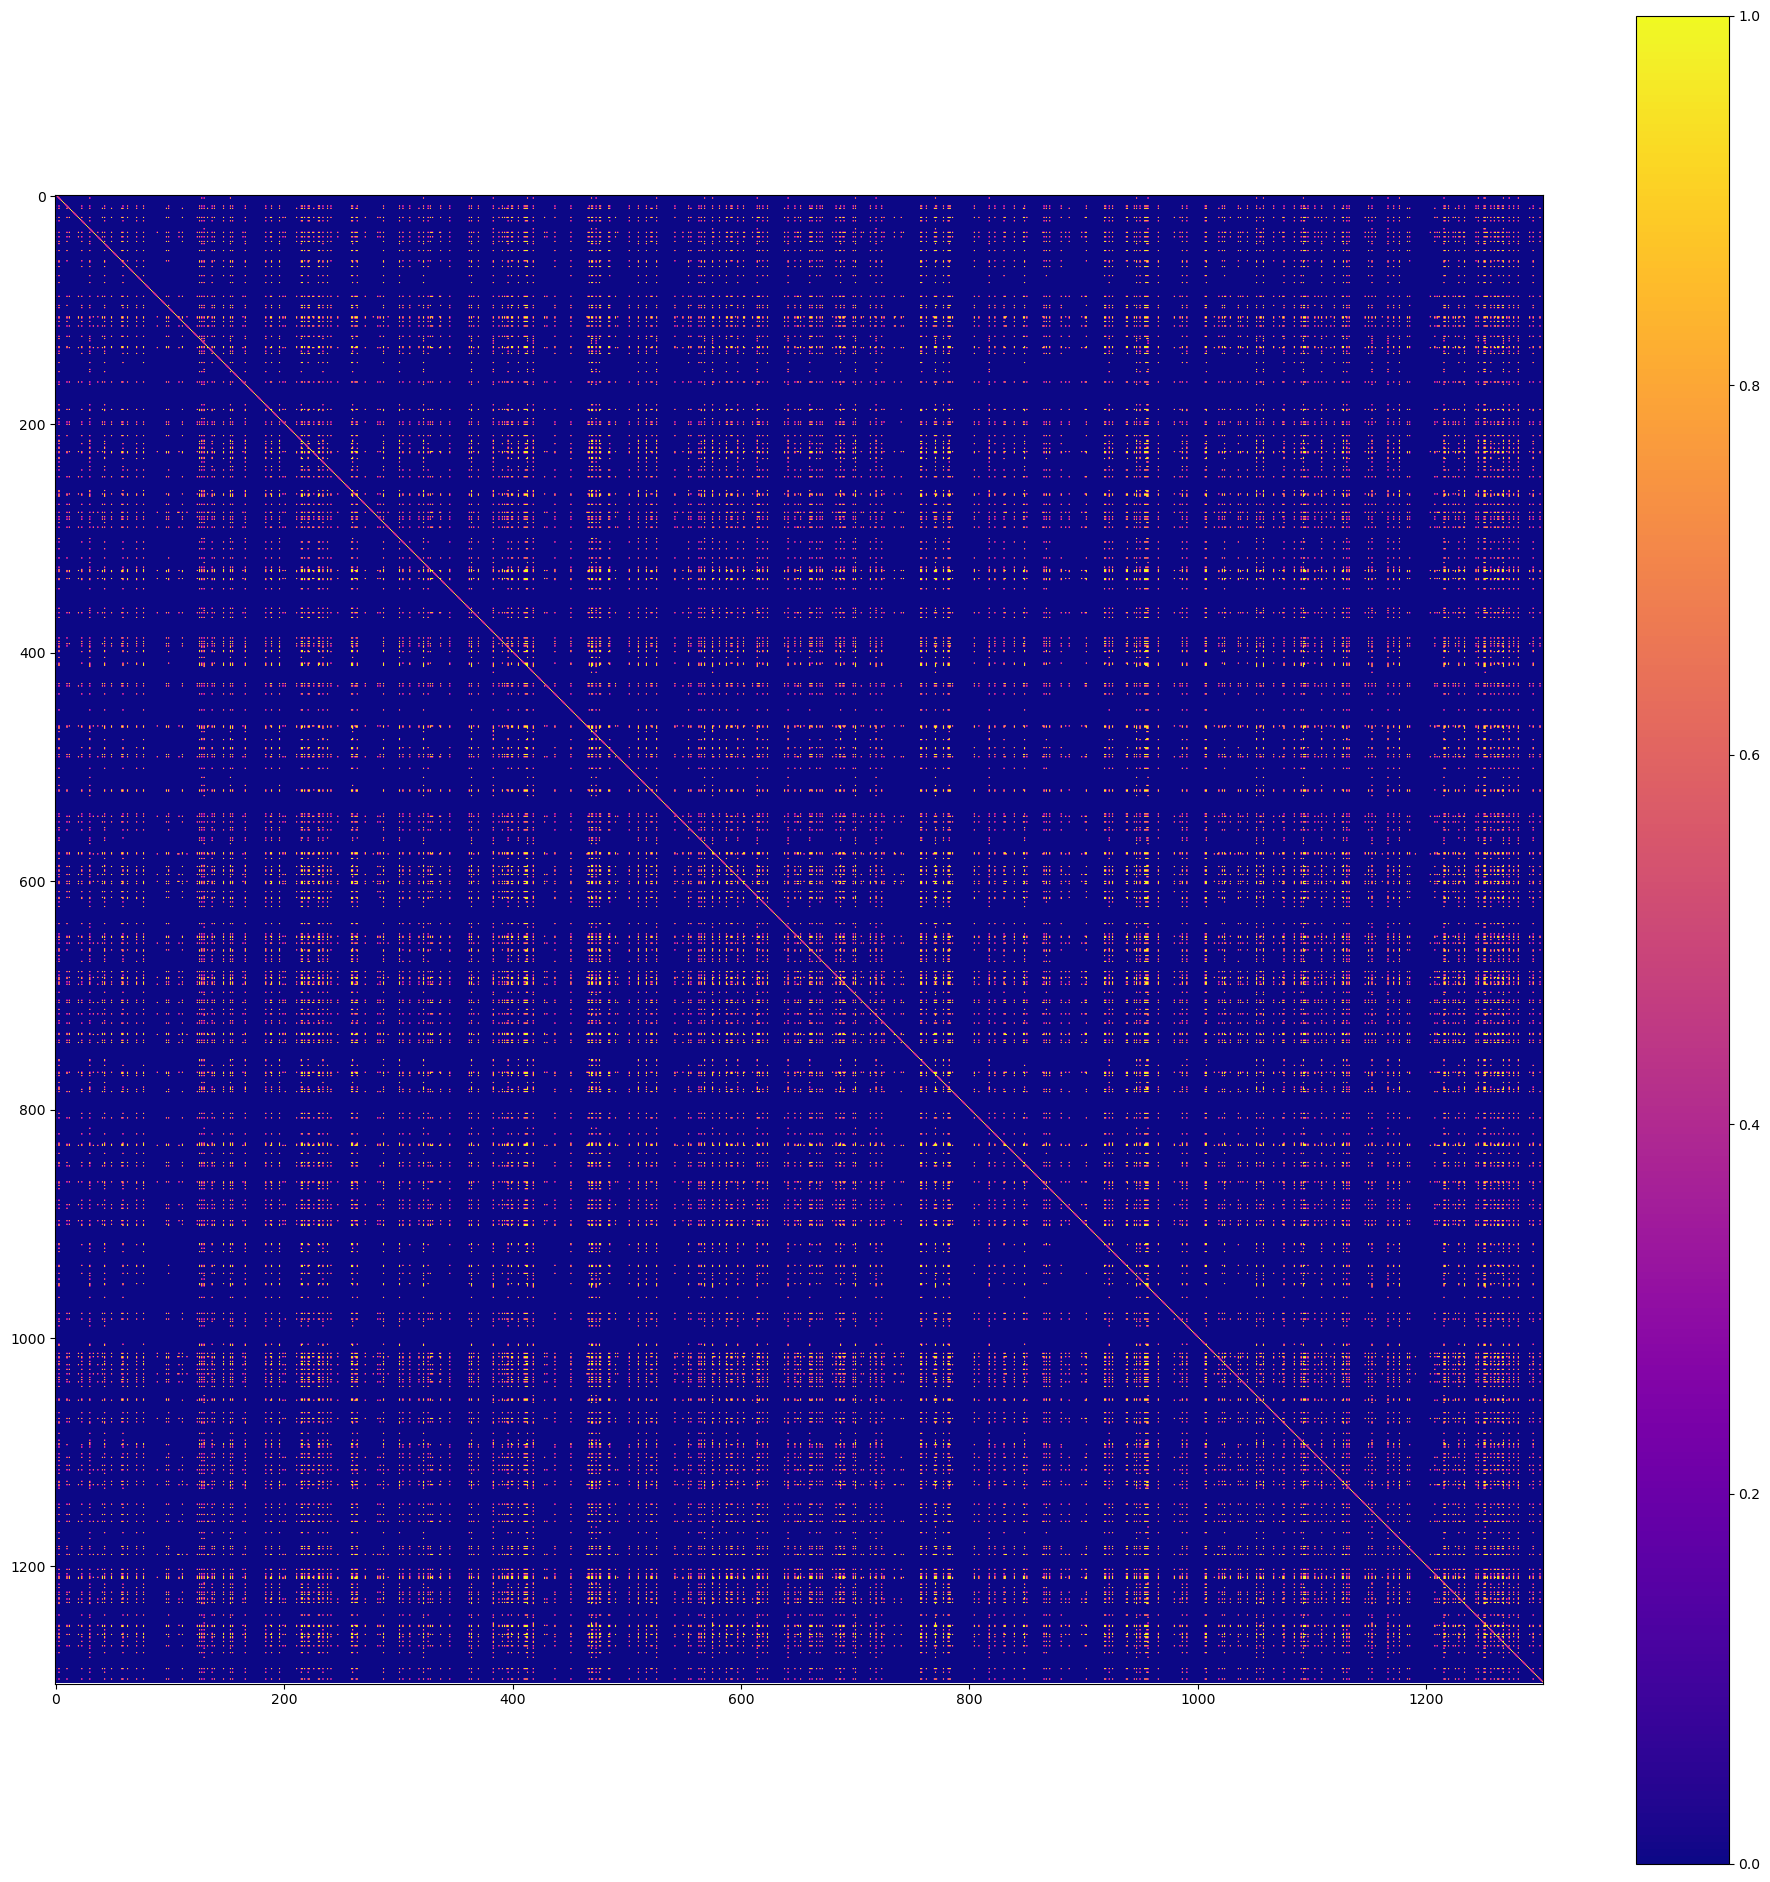

In [118]:
impossible_deps = 1*(adj <= (10-threshold))

fig, ax = plt.subplots(1, 1,figsize=(24,24))
im=ax.imshow(impossible_deps, cmap = "plasma")
fig.colorbar(im, ax=ax)
plt.savefig("../dat/wiki/adj_vis.png")

In [119]:
np.sum(impossible_deps) / impossible_deps.shape[0]**2 # percent of all dependencies that is ruled out

0.03019774309124289

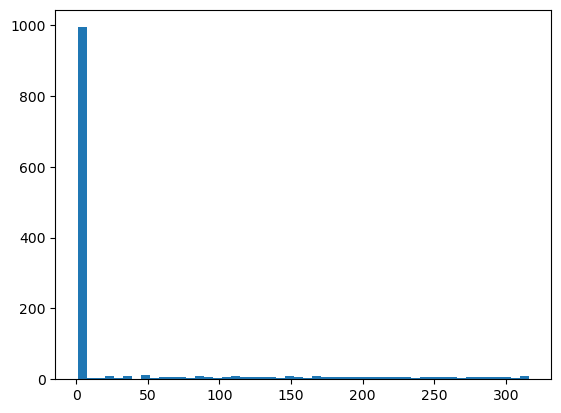

In [112]:
# histogram of dependencies ruled out per concept
num_outruled_per_concept = np.sum(impossible_deps, axis=0)
plt.hist(num_outruled_per_concept, bins=50)
plt.show()

In [8]:
np.save("../dash/dash_textbooks/data/adj.npy",adj)
np.save("../dash/dash_textbooks/data/wiki_concepts.npy",wiki_concepts)

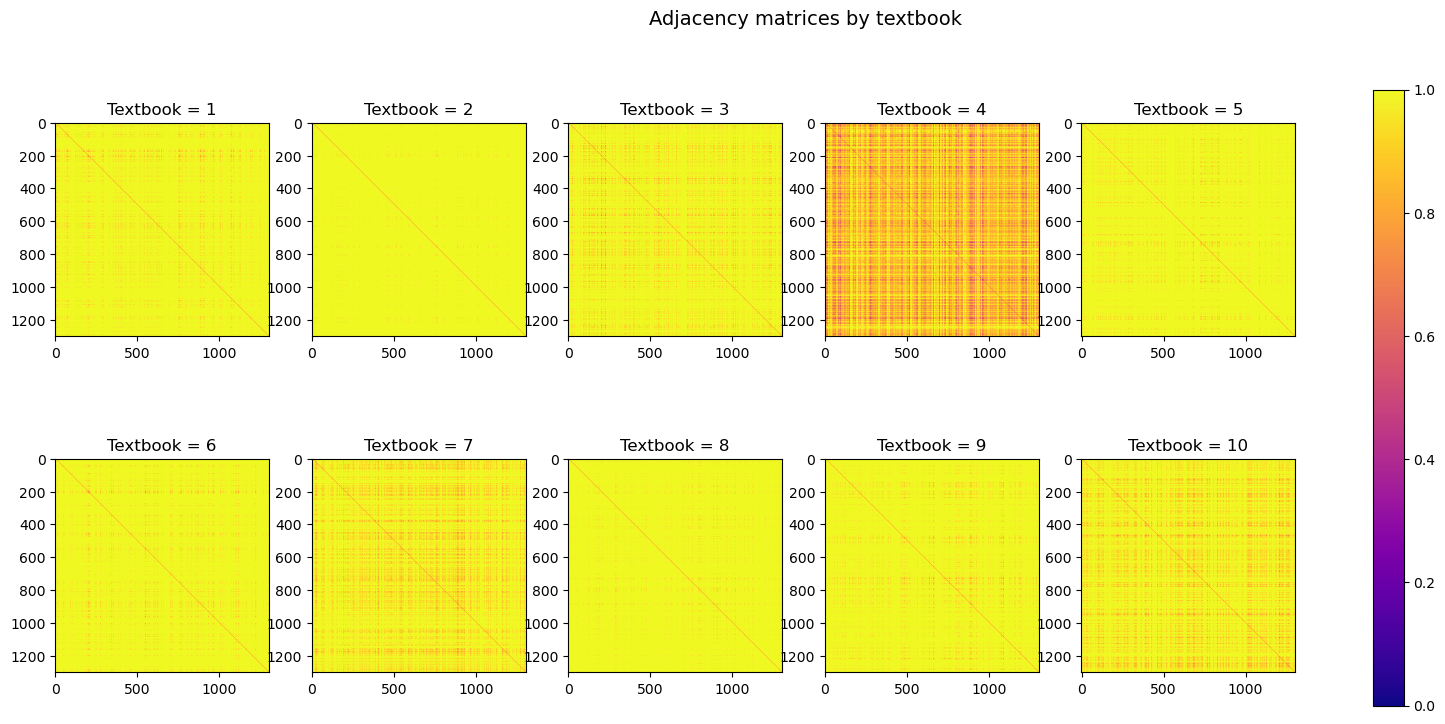

In [10]:
fig, axes = plt.subplots(2, 5,figsize=(20,8))

for i, ax in enumerate(axes.flatten()):
        im= ax.imshow(adj_by_book[i,:,:],cmap = "plasma")
        ax.title.set_text("Textbook = "+str(i+1))

fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle("Adjacency matrices by textbook",fontsize=14)
plt.show()

In [15]:
# Quality is good but the size of the image is terribly huge

#import plotly.express as px
#fig = px.imshow(adj_by_book[:,:,:], binary_string=False, facet_col=0, facet_col_wrap=5,labels={'facet_col':'textbook'})
#fig.write_html("../fig/adj_matrices_textbook.html")
#fig.write_image("../fig/adj_matrices_textbook.pdf")
#fig.show()

In [16]:
adj_filtered_nbook_thr = np.tile(0, (len(indices.keys()),n,n))

for nbook_thr in range(1,11):
    filter1 = (adj>=nbook_thr)
    filter2 = ((filter1+filter1.T)!=2)
    adj_filtered_nbook_thr[nbook_thr-1,:,:] = np.where(filter1  & filter2, adj, 0)


In [17]:
thr9 = adj_filtered_nbook_thr[8,:,:]
thr9[thr9>0]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

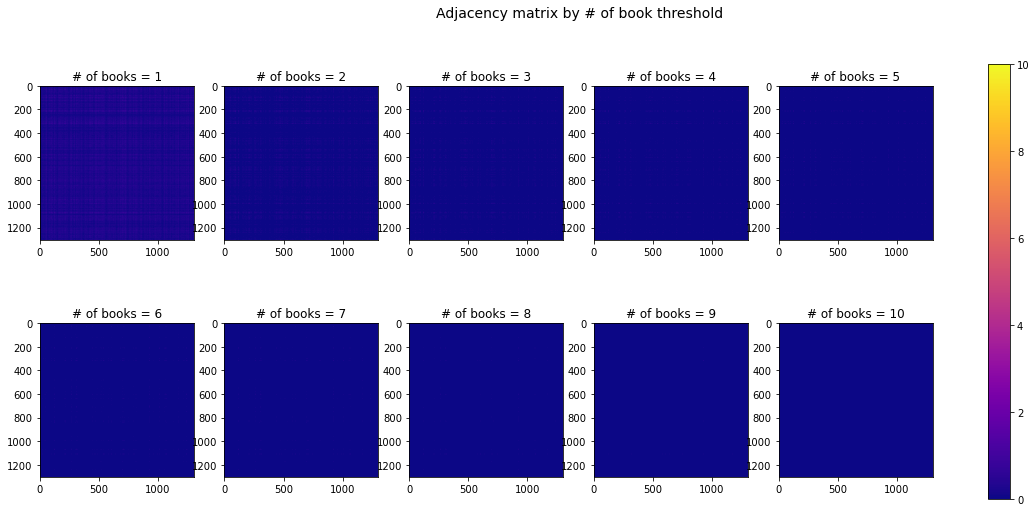

In [18]:
# not enough resolution to reflect all connections. Network illustrates the connections much better.
fig, axes = plt.subplots(2, 5,figsize=(20,8))

for i, ax in enumerate(axes.flatten()):
        im= ax.imshow(adj_filtered_nbook_thr[i,:,:], vmin=0, vmax=10, cmap = "plasma")
        ax.title.set_text("# of books = "+str(i+1))

fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle("Adjacency matrix by # of book threshold",fontsize=14)
plt.show()

In [19]:
# Quality is good but the size of the image is terribly huge

#fig = px.imshow(adj_filtered_nbook_thr[:,:,:], binary_string=False, facet_col=0, facet_col_wrap=5,labels={'facet_col':'# of book threshold'})

#for nbook_thr in range(1,11):
#    if nbook_thr <= 5:
#        fig.layout.annotations[nbook_thr + 4]['text'] = '# of book threshold = %d' %nbook_thr
#    else:
#        fig.layout.annotations[nbook_thr - 6]['text'] = '# of book threshold = %d' %nbook_thr

#fig.show()
#fig.write_html("../fig/adj_matrices_threshold.html")
#fig.write_image("../fig/adj_matrices_threshold.pdf", scale=0.3)